### Import Everything

In [17]:
# Import everything
import numpy as np
import cv2 as cv
import torch
from torch import nn
import os

C:\Users\totmi\anaconda\envs\anyloc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Processing of test and check images

Extract DINOv2 VLAD residuals + Make the color image

In [42]:
import cv2 as cv
import matplotlib.pyplot as plt
from torchvision.transforms import functional as T
from torchvision.datasets import ImageFolder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_img_size = 1024
show_clusters = [1, 2, 3, 6, 7]
alpha = 0.4

Image is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Patch descriptors: torch.Size([1, 3942, 1536])
Generated residuals: torch.Size([3942, 32, 1536])
Descriptor assignments shape: torch.Size([1022, 756])


<Figure size 512x384 with 0 Axes>

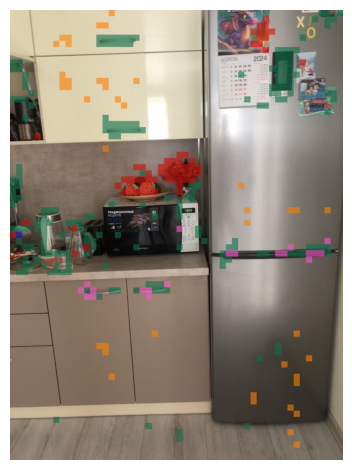

Image is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Patch descriptors: torch.Size([1, 3942, 1536])
Generated residuals: torch.Size([3942, 32, 1536])
Descriptor assignments shape: torch.Size([1022, 756])


<Figure size 512x384 with 0 Axes>

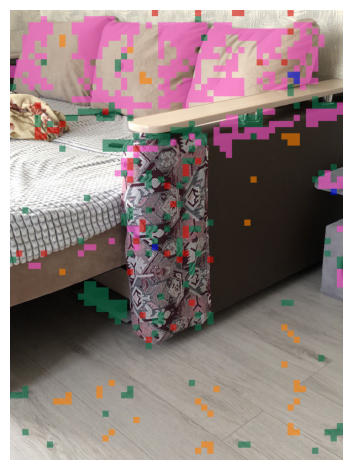

Image is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Patch descriptors: torch.Size([1, 3942, 1536])
Generated residuals: torch.Size([3942, 32, 1536])
Descriptor assignments shape: torch.Size([1022, 756])


<Figure size 512x384 with 0 Axes>

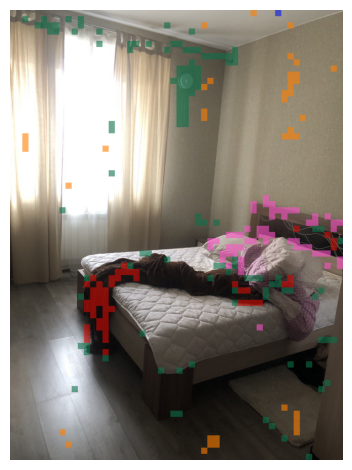

Image is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Patch descriptors: torch.Size([1, 3942, 1536])
Generated residuals: torch.Size([3942, 32, 1536])
Descriptor assignments shape: torch.Size([1022, 756])


<Figure size 512x384 with 0 Axes>

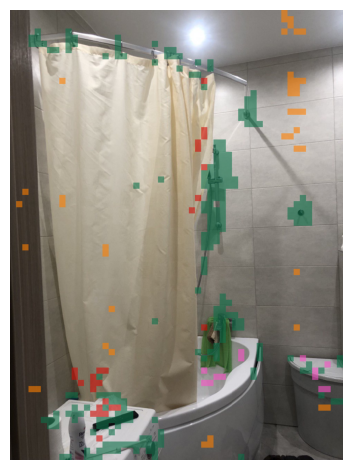

Image is too big! Resized from (h, w) =(1280, 960) To (h, w) =(1024, 768)
Patch descriptors: torch.Size([1, 3942, 1536])
Generated residuals: torch.Size([3942, 32, 1536])
Descriptor assignments shape: torch.Size([1022, 756])


<Figure size 512x384 with 0 Axes>

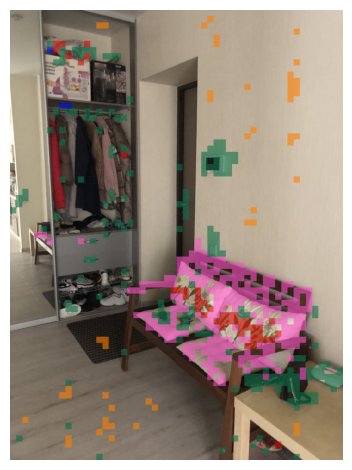

In [43]:
from torchvision.transforms import functional as T

# Пути к папкам с изображениями
image_folders = ["Kitchen", "Living_room", "Bedroom", "Bathroom", "Wardrobe"]

for folder in image_folders:
    #img_folder = f"tests/{folder}"
    img_folder = f"check/{folder}"
    img_files = os.listdir(img_folder)

    for img_file in img_files:
        if img_file.endswith(('.jpg', '.JPG' '.jpeg', '.png')):
            img_path = os.path.join(img_folder, img_file)
            assert os.path.isfile(img_path), f"Image {img_file} not found!"

            with torch.no_grad():
                # Read image
                pil_img = Image.open(img_path).convert('RGB')
                img_pt = base_tf(pil_img).to(device)
                if max(img_pt.shape[-2:]) > max_img_size:
                    print("Image is too big!", end=' ')
                    c, h, w = img_pt.shape
                    print(f"Resized from {(h, w) =}", end=' ')
                    # Maintain aspect ratio
                    if h == max(img_pt.shape[-2:]):
                        w = int(w * max_img_size / h)
                        h = max_img_size
                    else:
                        h = int(h * max_img_size / w)
                        w = max_img_size
                    print(f"To {(h, w) =}")
                    img_pt = T.resize(img_pt, (h, w), interpolation=T.InterpolationMode.BICUBIC)
                    pil_img = pil_img.resize((w, h))
                # Make image patchable
                c, h, w = img_pt.shape
                h_p, w_p = (h // 14), (w // 14)
                h_new, w_new = h_p * 14, w_p * 14
                img_pt = T.center_crop(img_pt, (h_new, w_new))[None, ...]
                img_np = F.interpolate(torch.tensor(np.array(pil_img)).permute(2, 0, 1)[None, ...], (h_new, w_new), mode='nearest')[0].permute(1, 2, 0).numpy()
                # Extract descriptors
                patch_desc = extractor(img_pt)

            patch_desc = patch_desc.cpu()
            print(f"Patch descriptors: {patch_desc.shape}")

            # VLAD residuals
            res_vect = vlad.generate_res_vec(patch_desc[0])
            print(f"Generated residuals: {res_vect.shape}")
            # Cluster assignments
            da = res_vect.abs().sum(dim=2).argmin(dim=1).reshape(h_p, w_p)
            da = F.interpolate(da[None, None, ...].to(float), (h_new, w_new))[0, 0].to(da.dtype)
            print(f"Descriptor assignments shape: {da.shape}")

            # Descriptor assignment clusters (all)
            da_img = np.zeros((*da.shape, 3), dtype=np.uint8)
            for c in range(num_c):
                da_img[da == c] = np_colors[c]

            # Blend mask
            if type(da) == torch.Tensor:
                da = da.numpy()
            merge_mask = np.zeros_like(da).astype(np.float32)
            for ci in show_clusters:
                merge_mask[da == ci] = 1

            # Merged image
            res_img = cv.addWeighted(img_np, alpha, da_img, (1-alpha), 0.0)
            res_img[merge_mask == 0] = img_np[merge_mask == 0]

            # Show and save the final visualization
            fig = plt.figure(figsize=(1024/200, 768/200)) # the size of the shape taking into account dpi
            fig, ax = plt.subplots()
            
            ax.imshow(res_img)
            ax.axis('off')
            fig.set_tight_layout(True)
            
            # Saving an image with specific clusters
            save_path = os.path.join(img_folder, f'{img_file[:-4]}.jpg')
            plt.savefig(save_path)
            plt.show()
            plt.close(fig)


## Processing 5: Further training of the model for classification task

Epoch [1/100], Train Loss: 137.35961985588074, Train Accuracy: 0.21333333333333335
Epoch [1/100], Val Loss: 11.884769797325134, Val Accuracy: 0.4
Epoch [2/100], Train Loss: 99.3565918803215, Train Accuracy: 0.21333333333333335
Epoch [2/100], Val Loss: 12.531919956207275, Val Accuracy: 0.2
Epoch [3/100], Train Loss: 100.5828189253807, Train Accuracy: 0.2577777777777778
Epoch [3/100], Val Loss: 11.579603731632233, Val Accuracy: 0.26666666666666666
Epoch [4/100], Train Loss: 90.1413688659668, Train Accuracy: 0.37333333333333335
Epoch [4/100], Val Loss: 12.009009301662445, Val Accuracy: 0.3
Epoch [5/100], Train Loss: 91.5362491607666, Train Accuracy: 0.31555555555555553
Epoch [5/100], Val Loss: 11.899630188941956, Val Accuracy: 0.3333333333333333
Epoch [6/100], Train Loss: 84.30247575044632, Train Accuracy: 0.3466666666666667
Epoch [6/100], Val Loss: 11.729351460933685, Val Accuracy: 0.3333333333333333
Epoch [7/100], Train Loss: 83.05608576536179, Train Accuracy: 0.39111111111111113
Epoch 

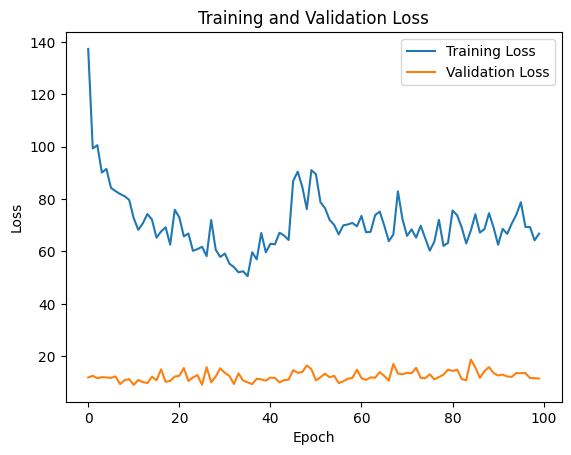

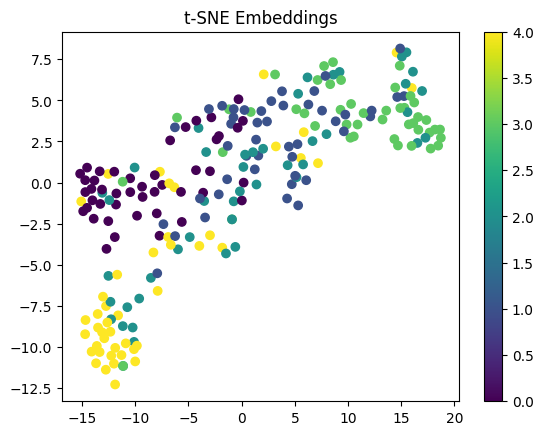

In [66]:
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
from timm.models import create_model

class RoomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.classes = {"Kitchen": 0, "Living_room": 1, "Bedroom": 2, "Bathroom": 3, "Wardrobe": 4}
        self.image_files = []
        for class_name in self.classes.keys():
            class_dir = os.path.join(data_dir, class_name)
            self.image_files.extend([(img_path, class_name) for img_path in os.listdir(class_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, class_name = self.image_files[idx]
        image = Image.open(os.path.join(self.data_dir, class_name, img_path)).convert("RGB")
        label = self.classes[class_name]
        if self.transform:
            image = self.transform(image)
        return image, label

class VITClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VITClassifier, self).__init__()
        self.model = create_model('vit_base_patch32_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

def compute_recalls(query_embeddings, ref_embeddings, soft_positives_per_query):
    device = soft_positives_per_query.device
    cos_sim_mat = F.cosine_similarity(query_embeddings[:, :, None], ref_embeddings.t()[None, :, :])
    _, ind_top1 = cos_sim_mat.topk(k=1, dim=-1)
    _, ind_top5 = cos_sim_mat.topk(k=min(5, cos_sim_mat.size(-1)), dim=-1)
    _, ind_top10 = cos_sim_mat.topk(k=min(10, cos_sim_mat.size(-1)), dim=-1)
    recalls = [0, 0, 0]
    for i in range(ind_top1.shape[0]):
        recalls[0] += torch.any(torch.isin(ind_top1[i].to(device), soft_positives_per_query[i])).float()
        recalls[1] += torch.any(torch.isin(ind_top5[i].to(device), soft_positives_per_query[i])).float()
        recalls[2] += torch.any(torch.isin(ind_top10[i].to(device), soft_positives_per_query[i])).float()
    recalls = [r.item() / ind_top1.shape[0] for r in recalls]
    return recalls

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    data_dir = "./cache/cache/imgs/indoor/"
    val_dir = "./tests/"
    num_classes = 5  # kitchen, living-room, bedroom, bathroom, wardrobe
    lr = 1e-3
    batch_size = 4
    num_epochs = 100
    val_every = 1

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = RoomDataset(data_dir, transform=transform)
    val_dataset = RoomDataset(val_dir, transform=transform)
    
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    
    model = VITClassifier(num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_values = []  # storing training loss 
    val_loss_values = []    # storing validation loss 

    soft_positives_per_query = torch.zeros(len(val_dataset), 10).long().to(device)

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_epoch_loss}, Train Accuracy: {train_accuracy}")
        train_loss_values.append(train_epoch_loss)

        # Validation
        if (epoch + 1) % val_every == 0 or epoch == num_epochs - 1:
            model.eval()
            val_epoch_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_epoch_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_epoch_loss}, Val Accuracy: {val_accuracy}")
            val_loss_values.append(val_epoch_loss)

    torch.save(model.state_dict(), 'trained_model_vit.pt')

    # Plot the training and validation loss values
    plt.plot(train_loss_values, label='Training Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot t-SNE Embeddings
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            all_embeddings.append(outputs)
            all_labels.append(labels)

    all_embeddings = torch.cat(all_embeddings)
    all_labels = torch.cat(all_labels)
    perplexity = min(30, len(all_embeddings) - 1)
    tsne_embeddings = TSNE(n_components=2, perplexity=perplexity).fit_transform(all_embeddings.cpu())

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=all_labels, cmap='viridis')
    plt.colorbar()
    plt.title('t-SNE Embeddings')
    plt.show()

if __name__ == "__main__":
    main()

## Input 2: User given image

Extract DINOv2 VLAD residuals + Make the color image

In [71]:
class RoomClassifier:
    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = VITClassifier(num_classes=5)
        self.model = self.model.to(self.device)

        try:
            # Load the trained weights
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
            self.model.eval()
        except RuntimeError as e:
            print(f"Error loading model weights: {e}")

    def classify_image(self, image_path):
        pil_img = Image.open(image_path).convert('RGB')
        img_tensor = transforms.Resize((224, 224))(pil_img)
        # Convert the PIL image to a PyTorch tensor
        img_tensor = transforms.ToTensor()(img_tensor).to(self.device)
        # Normalize the image tensor
        img_tensor = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_tensor)
        img_tensor = img_tensor.unsqueeze(0)

        with torch.no_grad():
            outputs = self.model(img_tensor)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
        
        predicted_class = predicted.item()
        probability = probabilities[0][predicted_class].item()
        class_probabilities = {class_idx: probability.item() for class_idx, probability in enumerate(probabilities[0])}
        
        return predicted_class, probability, class_probabilities

# Example
if __name__ == "__main__":
    model_path = 'trained_model_vit.pt'
    classifier = RoomClassifier(model_path)
    image_path = "./check/Living_room/living_room.jpg"
    predicted_class, probability, class_probabilities = classifier.classify_image(image_path)
    print(f"Predicted Class: {predicted_class}, Probability: {probability}")
    print("Class Probabilities:")
    for class_idx, prob in class_probabilities.items():
        print(f"Class {class_idx}: Probability {prob}")


Predicted Class: 1, Probability: 0.34786006808280945
Class Probabilities:
Class 0: Probability 0.16820736229419708
Class 1: Probability 0.34786006808280945
Class 2: Probability 0.13941475749015808
Class 3: Probability 0.28859323263168335
Class 4: Probability 0.05592462420463562


Done